# Deep Learning - Assignment 9

# Rachit Aggarwal - M12506500

## Importing required libraries

## Answer 10.1

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import time
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

C:\Users\rachi\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


## Defining graph

In [3]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

## Initializing placeholders for both DNNs

In [4]:
n_inputs = 28 * 28 # MNIST

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, 2, n_inputs), name="X")
X1, X2 = tf.unstack(X, axis=1)

## Initializing placeholder for label

In [5]:
y = tf.placeholder(tf.int32, shape=[None, 1])

## Defining DNN function with He initialization and ELU activation

In [7]:
he_init = tf.contrib.layers.variance_scaling_initializer()

def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None,
        activation=tf.nn.elu, initializer=he_init):
    with tf.variable_scope(name, "dnn"):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation,
                                     kernel_initializer=initializer,
                                     name="hidden%d" % (layer + 1))
        return inputs

## Feeding inputs to two separate DNN

In [8]:
dnn1 = dnn(X1, name="DNN_A")
dnn2 = dnn(X2, name="DNN_B")

## Concatenating the outputs

In [9]:
dnn_outputs = tf.concat([dnn1, dnn2], axis=1)

## Each DNN outputs 100 activations (per instance), so the shape is [None, 100]

In [10]:
dnn1.shape

TensorShape([Dimension(None), Dimension(100)])

In [11]:
dnn2.shape

TensorShape([Dimension(None), Dimension(100)])

## concatenated outputs have a shape of [None, 200]

In [13]:
dnn_outputs.shape

TensorShape([Dimension(None), Dimension(200)])

## Inserting new hidden layer with 10 neurons

In [15]:
hidden = tf.layers.dense(dnn_outputs, units=10, activation=tf.nn.elu, kernel_initializer=he_init)
logits = tf.layers.dense(hidden, units=1, kernel_initializer=he_init)
y_proba = tf.nn.sigmoid(logits)

## Predicting values based on logits values

In [16]:
y_pred = tf.cast(tf.greater_equal(logits, 0), tf.int32)

## Cost function

In [17]:
y_as_float = tf.cast(y, tf.float32)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float, logits=logits)
loss = tf.reduce_mean(xentropy)

## Optimizer

In [18]:
learning_rate = 0.01
momentum = 0.95

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

## measuring the accuracy of classifier

In [19]:
y_pred_correct = tf.equal(y_pred, y)
accuracy = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))

In [20]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

## Answer 10.2

## Separating training, validation and testing data

In [21]:
X_train1 = mnist.train.images
y_train1 = mnist.train.labels

X_train2 = mnist.validation.images
y_train2 = mnist.validation.labels

X_test = mnist.test.images
y_test = mnist.test.labels

## Function to generate pair of images 50% for each digit

In [22]:
def generate_batch(images, labels, batch_size):
    size1 = batch_size // 2
    size2 = batch_size - size1
    if size1 != size2 and np.random.rand() > 0.5:
        size1, size2 = size2, size1
    X = []
    y = []
    while len(X) < size1:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    rnd_indices = np.random.permutation(batch_size)
    return np.array(X)[rnd_indices], np.array(y)[rnd_indices]

## Batch of 5 image pair

In [23]:
batch_size = 5
X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)

In [24]:
X_batch.shape, X_batch.dtype

((5, 2, 784), dtype('float32'))

## Plotting the pair of imgaes from the batch

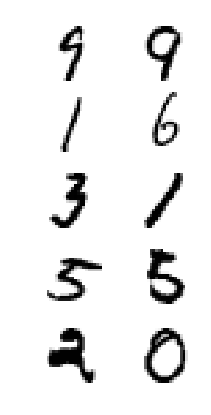

In [25]:
plt.figure(figsize=(3, 3 * batch_size))
plt.subplot(121)
plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.subplot(122)
plt.imshow(X_batch[:,1].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.show()

## checking the labels

In [26]:
y_batch

array([[1],
       [0],
       [0],
       [1],
       [0]])

## Answer 10.3

## Generating a test set of many pairs of images

In [27]:
X_test1, y_test1 = generate_batch(X_test, y_test, batch_size=len(X_test))

## Training the model

In [28]:
n_epochs = 100
batch_size = 500

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)
            loss_val, _ = sess.run([loss, training_op], feed_dict={X: X_batch, y: y_batch})
        print(epoch, "Train loss:", loss_val)
        if epoch % 5 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_digit_comparison_model.ckpt")

0 Train loss: 0.60465544
0 Test accuracy: 0.6997
1 Train loss: 0.36080956
2 Train loss: 0.30109534
3 Train loss: 0.2616911
4 Train loss: 0.21387331
5 Train loss: 0.1875908
5 Test accuracy: 0.9159
6 Train loss: 0.21559455
7 Train loss: 0.18048915
8 Train loss: 0.18577994
9 Train loss: 0.16092974
10 Train loss: 0.12513581
10 Test accuracy: 0.9375
11 Train loss: 0.17866379
12 Train loss: 0.1242573
13 Train loss: 0.11760525
14 Train loss: 0.09440907
15 Train loss: 0.09654444
15 Test accuracy: 0.9521
16 Train loss: 0.14447895
17 Train loss: 0.09864418
18 Train loss: 0.11442176
19 Train loss: 0.12862927
20 Train loss: 0.124105126
20 Test accuracy: 0.96
21 Train loss: 0.073349416
22 Train loss: 0.102564454
23 Train loss: 0.09699113
24 Train loss: 0.117153294
25 Train loss: 0.0812609
25 Test accuracy: 0.9651
26 Train loss: 0.08908055
27 Train loss: 0.063645974
28 Train loss: 0.06657938
29 Train loss: 0.055384055
30 Train loss: 0.058819544
30 Test accuracy: 0.9664
31 Train loss: 0.07524643
32 T

## Answer 10.4

## Creating the model

## Freezing lower layers by using tf.stop.gradient() function

## 2 savers, one for DNN A and other for final model

In [29]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")
frozen_outputs = tf.stop_gradient(dnn_outputs)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

## Training the model on small MNIST dataset

In [30]:
n_epochs = 100
batch_size = 50

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_digit_comparison_model.ckpt")

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_digit_comparison_model.ckpt
0 Test accuracy: 0.937
10 Test accuracy: 0.9601
20 Test accuracy: 0.9638
30 Test accuracy: 0.9643
40 Test accuracy: 0.9642
50 Test accuracy: 0.9642
60 Test accuracy: 0.9642
70 Test accuracy: 0.9645
80 Test accuracy: 0.9647
90 Test accuracy: 0.9647


## DNN classifier without transfer learning

In [33]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

## Comparing the accuracy of DNN without transfer learning and with transfer learning

In [34]:
n_epochs = 150
batch_size = 50

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

0 Test accuracy: 0.8893
10 Test accuracy: 0.9403
20 Test accuracy: 0.9476
30 Test accuracy: 0.9476
40 Test accuracy: 0.948
50 Test accuracy: 0.9476
60 Test accuracy: 0.9476
70 Test accuracy: 0.9472
80 Test accuracy: 0.9475
90 Test accuracy: 0.9472
100 Test accuracy: 0.9472
110 Test accuracy: 0.9474
120 Test accuracy: 0.9474
130 Test accuracy: 0.9474
140 Test accuracy: 0.9475


## Transfer learning improved he accuracy value.